In [13]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [15]:
import time as timestamp 
import importlib

In [16]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb
import LIM_building as limbuild

sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [6]:
#--------------------------------------------------
# START USER PARAMETERS
#--------------------------------------------------
# number of EOFs to retain for the LIM state vector
ntrunc = 40 # EOF truncation for individual fields (reduced-state space)
nmodes = 40 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 20
nmodes_sic = 40
#modes_sic = 20

lat_cutoff = 50

mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january
# nyearstrain = 30
# ntrain = int(nyearstrain*12)
# nvalid = int(38*12)
# nyearsvalid = 38-nyearstrain
# nvalidtimes = 1872

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
# limvars = ['tas','tos','psl','sit','sic']
# limvars_nosic = ['tas','tos','psl','sit']
limvars = ['tas','sic']
#limvars = ['sic']
limvars_nosic = []
nvars = len(limvars)

# specify the model source 
#train_dsource = 'satellite'
#train_dsource = 'cmip6_mpi_hist_ssp585'
train_dsource = 'cmip6_mpi_hist'
#train_dsource ='satellite'
#train_dsource = 'mpi_hist_kb'
#train_dsource = 'ccsm4_lm_kb'
#train_dsource = 'era5'
#train_dsource = 'satellite'
#valid_dsource = 'era5'
#valid_dsource = 'satellite'
#valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'mpi_lm_kb'
valid_dsource = 'cmip6_mpi_hist'

sic_separate = False
Insamp = False

# date_of_interest = '20210910'

In [7]:
if 'hist_ssp585' in train_dsource: 
    folder_add = 'hist_ssp585_concatenated/'
elif 'hist' in train_dsource: 
    folder_add = 'historical/'
elif 'lm' in train_dsource: 
    folder_add = 'last_millennium/'
elif 'satellite' in train_dsource: 
    folder_add = 'satellite/'
elif 'era5' in train_dsource: 
    folder_add = 'reanalysis/'

In [8]:
# Start with truncated training data: 
#mod_folder = 'truncated_model_data/last_millennium/'
mod_folder = 'truncated_model_data/'+folder_add

#mod_filename = '_ntrunc15_monthall_era5_latcutoff_50_wtTrue_dtTrue_ntrain_1979_2004_20211005.pkl'
#mod_filename = '_ntrunc'+str(nmodes)+'_month'+str(mo)+'_era5_latcutoff_50_wtFalse_dtFalse_ntrain_1979_2012_20211012.pkl'
mod_filename = ('_ntrunc'+str(ntrunc)+'_monthall_'+train_dsource+'_latcutoff_'+
                str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl')

mod_sic_filename = ('_ntrunc'+str(nmodes_sic)+'_monthall_'+train_dsource+'_latcutoff_'+
                    str(lat_cutoff)+'_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl')
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_monthall_satellite_latcutoff_50_wtTrue_dtTrue_ntrain_1979_2004_20210929.pkl'
#mod_sic_filename = '_ntrunc'+str(nmodes_sic)+'_month'+str(mo)+'_era5_latcutoff_50_wtFalse_dtFalse_ntrain_1979_2012_20211012.pkl'

In [9]:
exp_setup = {}
exp_setup['mo'] = mo
if 'all' in str(mo): 
    exp_setup['ind_month_trunc'] = False
else: 
    exp_setup['ind_month_trunc'] = True
exp_setup['tau'] = tau
exp_setup['ntrunc'] = ntrunc 
exp_setup['nmodes'] = nmodes 
exp_setup['nmodes_sic'] = nmodes_sic
exp_setup['limvars'] = limvars
exp_setup['train_dsource'] = train_dsource
exp_setup['valid_dsource'] = valid_dsource 
exp_setup['sic_separate'] = sic_separate
exp_setup['Insamp'] = Insamp
exp_setup['mod_folder'] = mod_folder
exp_setup['mod_filename'] = mod_filename
exp_setup['mod_sic_filename'] = mod_sic_filename
exp_setup['lat_cutoff'] = 50
exp_setup['Weight']=False
exp_setup['step2_trunc'] = True

# era5 settings (Juan etal 2016 - in sample): 
exp_setup['nyearsvalid'] = 26
exp_setup['nyearstot'] = 42
exp_setup['nyears_startvalid'] = 1*12

# era5 settings (out of sample): 
# exp_setup['nyearsvalid'] = 16
# exp_setup['nyearstot'] = 42
# exp_setup['nyears_startvalid'] = 26*12

# era5 settings (in sample):  
# exp_setup['nyearsvalid'] = 26
# exp_setup['nyearstot'] = 42
# exp_setup['nyears_startvalid'] = 1*12

# # Satellite settings (out of sample): 
# exp_setup['nyearsvalid'] = 12
# exp_setup['nyearstot'] = 38
# exp_setup['nyears_startvalid'] = 26*12

# Satellite settings (in sample): 
# exp_setup['nyearsvalid'] = 25
# exp_setup['nyearstot'] = 38
# exp_setup['nyears_startvalid'] = 1*12

# Historical settings: 
# exp_setup['nyearsvalid'] = 11
# exp_setup['nyearstot'] = 164
# exp_setup['nyears_startvalid'] = 154*12

# LM settings
# exp_setup['nyearsvalid'] = 10
# exp_setup['nyearstot'] = 1000
# exp_setup['nyears_startvalid'] = 900*12
exp_setup['ntrain']=((exp_setup['nyearstot']*12)-(exp_setup['nyearsvalid'] *12))/(exp_setup['nyearstot']*12)

In [10]:
month_names = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

In [11]:
import run_forecast_model_data as rf

In [17]:
importlib.reload(rf)
importlib.reload(limbuild)
importlib.reload(limkb)
importlib.reload(statskb)

<module 'LIM_stats_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_stats_kb.py'>

In [18]:
master_save = False

In [19]:
exp_setup['mod_folder']+exp_setup['mod_sic_filename']

'truncated_model_data/historical/_ntrunc40_monthall_cmip6_mpi_hist_latcutoff_50_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl'

In [20]:
# #--------------------------------------------------
# ### Build L from truncated data: 
# #--------------------------------------------------

# save_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

# LIMd = rf.build_L(exp_setup, save_folder, save=master_save)

In [21]:
full_names, areawt_name, month_names = limbuild.load_full_names()

#--------------------------------------------------
# BUILD L FROM PRE-TRUNCATED DATA: 
#--------------------------------------------------

[Ptrunc, _, E3, tot_var, 
 tot_var_eig, W_all, standard_factor, 
 nyears_train, var_dict] = limbuild.load_training_data_truncated(exp_setup['limvars'], exp_setup['mod_folder'], 
                                                                 exp_setup['mod_sic_filename'], 
                                                                 exp_setup['mod_filename'], 
                                                                 exp_setup['mo'],exp_setup['nyearstot'], 
                                                                 exp_setup['nyearsvalid'],
                                                                 ind_month_trunc=exp_setup['ind_month_trunc'])

var_dict = limbuild.get_var_indices(exp_setup['limvars'], var_dict)

ndof_all = limkb.count_ndof_all(exp_setup['limvars'], E3, sic_separate=False)

Loading truncated tas from: truncated_model_data/historical/tas_ntrunc40_monthall_cmip6_mpi_hist_latcutoff_50_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl
Month is all
Loading truncated sic from: truncated_model_data/historical/sic_ntrunc40_monthall_cmip6_mpi_hist_latcutoff_50_wtTrue_dtTrue_ntrain_1850_2004_20211014.pkl
Month is all
working on tas
working on sic
4032
30400


In [474]:
mod_folder = exp_setup['mod_folder']
mod_fname = exp_setup['mod_sic_filename']
var = 'tas'

[X_var, vt, E3t, standard_factor[var], 
 W_allt] = limkb.load_truncated_data(var, mod_folder, mod_fname)

Loading truncated tas from: truncated_model_data/tas_ntrunc40_monthall_era5_latcutoff_50_wtFalse_dtFalse_ntrain_1979_2012_20211012.pkl


In [478]:
nyearstot = exp_setup['nyearstot']
nyearsvalid = exp_setup['nyearsvalid']

print('Month is '+str(mo))
X_t = X_var
ntime = X_t.shape[1]
nyears_train = (nyearstot - nyearsvalid)*12
nyears_valid = ntime - nyears_train

X_train = X_t[:,0:nyears_train]
X_train_2d = X_train
X_valid = X_t[:,nyears_train:]

Month is all


In [480]:
nyearstot, nyearsvalid

(42, 26)

In [451]:
if len(exp_setup['limvars'])<=1:
    print('Only one variable detected...')
    Ptrunc_all = []
    E3_all = []
    Ptrunc_sic = Ptrunc['sic']
    E_sic = E3['sic']

    P_train = Ptrunc_sic
else: 
    print('Multiple variables detected...')
    if exp_setup['sic_separate']: 
        [Ptrunc_all, E3_all, 
        Ptrunc_sic,E_sic] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all, 
                                                      exp_setup['ntrunc'], Ptrunc, E3,var_dict,
                                                      sic_separate=exp_setup['sic_separate'])
        if step2_decomp: 
            [P_train, Fvar, Etrunc] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, Ptrunc_sic, 
                                                                        sic_separate=exp_setup['sic_separate'],
                                                                        Trunc_truth=False)
        else: 
            P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)
        
    else: 
        [Ptrunc_all, E3_all] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all, 
                                                      exp_setup['ntrunc'], Ptrunc, E3,var_dict,
                                                      sic_separate=exp_setup['sic_separate'])
        if step2_decomp: 
            [P_train, Fvar, Etrunc] = limkb.step2_multivariate_compress(Ptrunc_all,nmodes, E3_all, 0, 
                                                                        sic_separate=exp_setup['sic_separate'],
                                                                        Trunc_truth=False)
        else: 
            P_train = np.concatenate((Ptrunc_all, Ptrunc_sic),axis=0)

Multiple variables detected...
Fraction in first 40 multivariate EOFs = 92.42520545248053
Shape of E: (174960, 40)


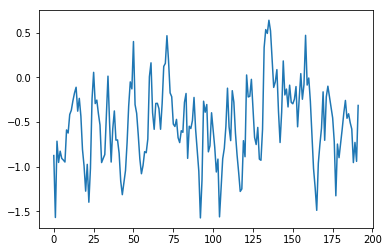

In [455]:
plt.plot(P_train[0,:])

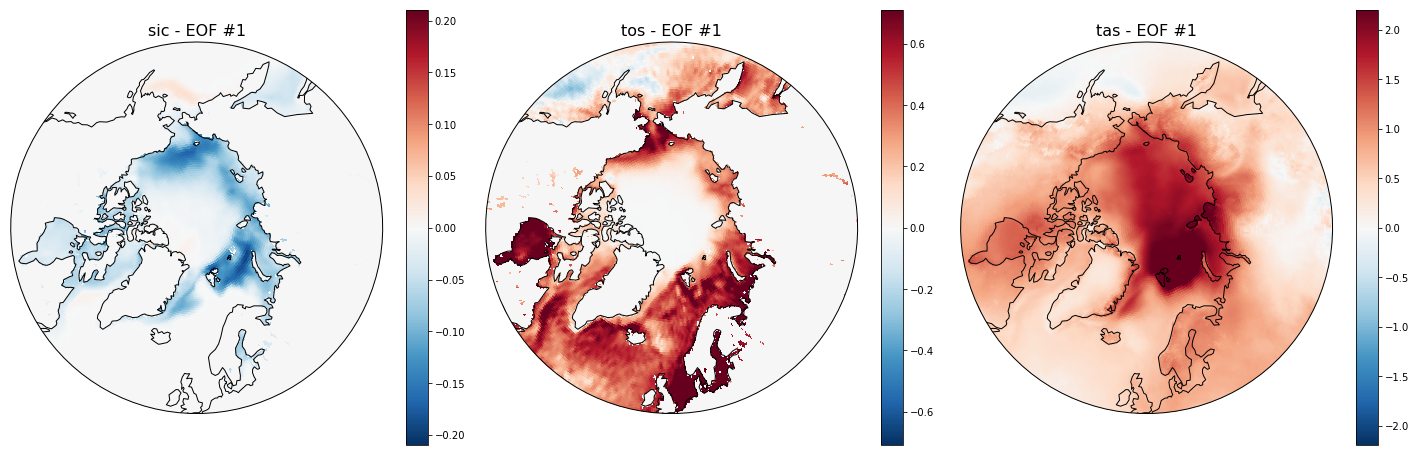

In [456]:
import matplotlib.path as mpath
mode = 0

limits = {'sic':0.21,'tas':2.2, 'tos':0.71}

fig, axs = plt.subplots(1,3,figsize=(20,7),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,var in enumerate(['sic','tos','tas']):
    nlat = var_dict[var]['lat'].shape[0]
    nlon = var_dict['tas']['lon'].shape[0]

    E_var = Etrunc[var_dict[var]['var_inds'],:]
    E_var_2d = np.reshape(E_var,(nlat,nlon,E_var.shape[1]))
    
    ax[i].set_title(var + ' - EOF #'+str(mode+1), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(E_var_2d[(var_dict[var]['lat']>0),mode]))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],#*lat_mask, #[:,:,0],
                          var_dict[var]['lat'],#*lat_mask, #[:,:,0],
                          E_var_2d[:,:,mode],cmap='RdBu_r', 
                          transform=ccrs.PlateCarree(),vmin=-limits[var],vmax=limits[var])
    fig.colorbar(cf, ax=ax[i])
    
#plt.suptitle('Satellite SIC EOFs (no area weighting)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

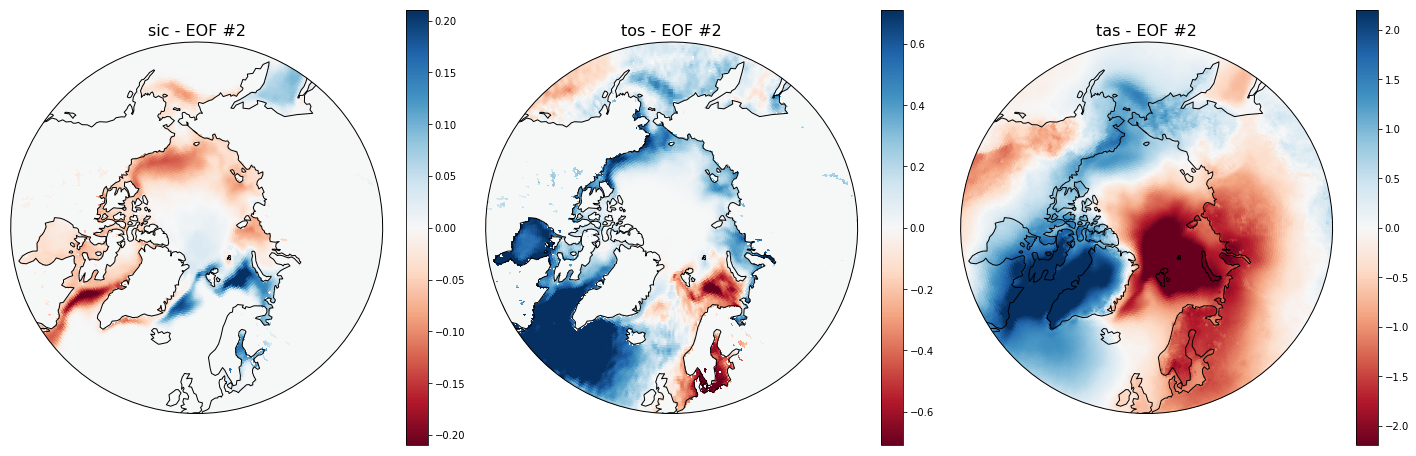

In [457]:
mode = 1

fig, axs = plt.subplots(1,3,figsize=(20,7),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,var in enumerate(['sic','tos','tas']):
    nlat = var_dict[var]['lat'].shape[0]
    nlon = var_dict['tas']['lon'].shape[0]

    E_var = Etrunc[var_dict[var]['var_inds'],:]
    E_var_2d = np.reshape(E_var,(nlat,nlon,E_var.shape[1]))
    
    ax[i].set_title(var + ' - EOF #'+str(mode+1), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(E_var_2d[(var_dict[var]['lat']>0),mode]))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],#*lat_mask, #[:,:,0],
                          var_dict[var]['lat'],#*lat_mask, #[:,:,0],
                          E_var_2d[:,:,mode],cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-limits[var],vmax=limits[var])
    fig.colorbar(cf, ax=ax[i])
    
#plt.suptitle('Satellite SIC EOFs (no area weighting)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

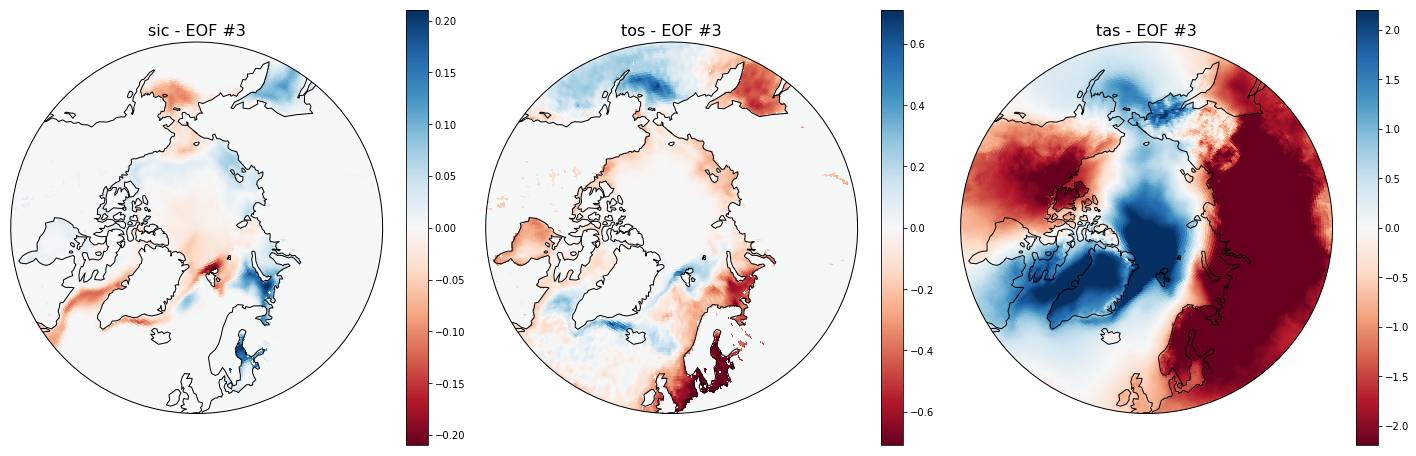

In [458]:
mode = 2

fig, axs = plt.subplots(1,3,figsize=(20,7),subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax = axs.flatten()
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

for i,var in enumerate(['sic','tos','tas']):
    nlat = var_dict[var]['lat'].shape[0]
    nlon = var_dict['tas']['lon'].shape[0]

    E_var = Etrunc[var_dict[var]['var_inds'],:]
    E_var_2d = np.reshape(E_var,(nlat,nlon,E_var.shape[1]))
    
    ax[i].set_title(var + ' - EOF #'+str(mode+1), fontsize=16)
    ax[i].coastlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
    
    m = np.max(np.abs(E_var_2d[(var_dict[var]['lat']>0),mode]))
    cf = ax[i].pcolormesh(var_dict[var]['lon'],#*lat_mask, #[:,:,0],
                          var_dict[var]['lat'],#*lat_mask, #[:,:,0],
                          E_var_2d[:,:,mode],cmap='RdBu', 
                          transform=ccrs.PlateCarree(),vmin=-limits[var],vmax=limits[var])
    fig.colorbar(cf, ax=ax[i])
    
#plt.suptitle('Satellite SIC EOFs (no area weighting)', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [463]:
P_train.shape[1]/12, nyears_train, 2012-1979

(16.0, 192, 33)

In [462]:
# TRAIN LIM: 
#--------------------------------------------------

nmo = int(P_train.shape[1]/nyears_train)
# nmo = 2
P_train_3d = np.reshape(P_train, (P_train.shape[0],int(nyears_train),nmo))

if exp_setup['mo'] is 'all':
    print('Using months: '+exp_setup['mo'])
    LIMd, G2 = lim.LIM_train(exp_setup['tau'],P_train)
    print('Training LIM with tau = '+str(exp_setup['tau']))
else: 
    print('Using months: '+str(exp_setup['mo']))
    LIMd, G2 = lim.LIM_train_flex(exp_setup['tau'],P_train_3d[:,:,0], P_train_3d[:,:,1])
    print('Training LIM with tau = '+str(exp_setup['tau']))


ValueError: cannot reshape array of size 7680 into shape (40,192,16)

In [439]:
max_eigenval = np.real(LIMd['lam_L']).max()

if max_eigenval >0: 
    LIMd['lam_L_adj'] = LIMd['lam_L'] - (max_eigenval+0.01)
else: 
    LIMd['lam_L_adj'] = LIMd['lam_L']

LIMd['npos_eigenvalues'] = (LIMd['lam_L']>0).sum()/(LIMd['lam_L'].shape[0])
print('Number of positive eigenvalues = '+ str((LIMd['lam_L']>0).sum()/(LIMd['lam_L'].shape[0])))

LIMd['E3'] = E3
LIMd['W_all'] = W_all
LIMd['standard_factor'] = standard_factor
LIMd['E3_all'] = E3_all
LIMd['E_sic'] = E_sic
LIMd['var_dict'] = var_dict
LIMd['P_train'] = P_train
LIMd['exp_setup'] = exp_setup
LIMd['Etrunc'] = Etrunc

Number of positive eigenvalues = 0.85


## Run Forecast: 

In [361]:
lags = [0,1,2,3,4,5,6]

if LIMd['npos_eigenvalues'] >0: 
    adj = True
else: 
    adj = False

exp_setup['lags'] = lags
exp_setup['adj'] = adj
exp_setup['remove_climo'] = True
exp_setup['detrend'] = False
exp_setup['nyr_train'] = None
exp_setup['Insamp'] = Insamp

f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

In [362]:
save_decomp=True
verbose=True

In [363]:
#forecast = rf.run_forecast(LIMd,exp_setup, f_folder, verbose=True, save=master_save, save_decomp=False)

In [364]:
fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])
    
Ptrunc_valid = {}
var_dict_valid = {}
ntims = len(exp_setup['lags'])
print('Validation data: '+exp_setup['valid_dsource'])

for k, var in enumerate(exp_setup['limvars']): 
    tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
    print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

    X_var_valid, var_dict_valid = limkb.load_data(var, var_dict_valid, fdic_valid, 
                                                  remove_climo=exp_setup['remove_climo'], 
                                                  detrend=exp_setup['detrend'], verbose=verbose, 
                                                  tscut=int(exp_setup['nyears_startvalid']/12), 
                                                  tecut=tecut, lat_cutoff=exp_setup['lat_cutoff'])
    if var is 'sic':
        if np.nanmax(X_var_valid)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_valid = X_var_valid/100

    print('Validation shape: '+str(X_var_valid.shape))

    if 'datetime64' in str(type(var_dict_valid[var]['time'][0])):
        print('time dimension: '+str(var_dict_valid[var]['time'][0].astype('M8[Y]'))+' - '+
              str(var_dict_valid[var]['time'][-1].astype('M8[Y]')))
        print(var_dict_valid[var]['time'].shape)
    else: 
        print('time dimension: '+str(var_dict_valid[var]['time'][0].year)+' - '+
              str(var_dict_valid[var]['time'][-1].year))
        print(var_dict_valid[var]['time'].shape)

    Ptrunc_valid[var] = limkb.step1_projection_validation_var(X_var_valid, LIMd['E3'][var], 
                                                              LIMd['standard_factor'][var],
                                                              LIMd['W_all'][var], Weights=exp_setup['Weight'])

var_dict_valid = limbuild.get_var_indices(exp_setup['limvars'], var_dict_valid)
ndof_all_valid = limkb.count_ndof_all(exp_setup['limvars'], LIMd['E3'], sic_separate=exp_setup['sic_separate'])

if len(exp_setup['limvars'])<=1:
    print('Only one variable detected...')
    Ptrunc_all_valid = []
    E3_all_valid = []
    Ptrunc_sic_valid = Ptrunc_valid['sic']
    E_sic_valid = LIMd['E3']['sic']

    P_train_valid = Ptrunc_sic_valid
else: 
    print('Multiple variables detected...')
    if exp_setup['sic_separate']:
        [Ptrunc_all_valid, E3_all_valid,
         Ptrunc_sic_valid, E_sic_valid] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all_valid, 
                                                                    exp_setup['ntrunc'],Ptrunc_valid, 
                                                                    LIMd['E3'], var_dict_valid, 
                                                                    sic_separate=exp_setup['sic_separate'])
        if exp_setup['step2_trunc']:
            [P_train_valid, Fvar, 
             E_train_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,exp_setup['nmodes'], E3_all_valid, 
                                                                     Ptrunc_sic_valid,
                                                                     sic_separate=exp_setup['sic_separate'],
                                                                     Trunc_truth=False)
        else: 
            P_train_valid = np.concatenate((Ptrunc_all_valid, Ptrunc_sic_valid),axis=0)    

    else: 
        [Ptrunc_all_valid, E3_all_valid] = limkb.stack_variable_eofs(exp_setup['limvars'], ndof_all_valid, 
                                                                     exp_setup['ntrunc'],Ptrunc_valid, 
                                                                     LIMd['E3'], var_dict_valid, 
                                                                     sic_separate=exp_setup['sic_separate'])
        if exp_setup['step2_trunc']:
            [P_train_valid, Fvar, 
             E_train_valid] = limkb.step2_multivariate_compress(Ptrunc_all_valid,exp_setup['nmodes'], 
                                                                     E3_all_valid,0,
                                                                     sic_separate=exp_setup['sic_separate'],
                                                                     Trunc_truth=False)
        else: 
            P_train_valid = Ptrunc_all_valid   

#        P_train_valid = np.concatenate((Ptrunc_all_valid, Ptrunc_sic_valid),axis=0)
print('P_train_valid: '+str(P_train_valid.shape))

Validation data: era5
tecut = 27, tscut = 1.0
Loading from tas
Loading from cuments/SeaIceData/ERA5/tas_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing climotology...
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.26036834716796875 seconds
-----------------------------------------------------
Validation shape: (58320, 312)
time dimension: 1980 - 2005
(312,)
tecut = 27, tscut = 1.0
Loading from tos
Loading from cuments/SeaIceData/ERA5/tos_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing climotology...
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.34889960289001465 seconds
-----------------------------------------------------
Validation shape: (58320, 312)
time dimension: 1980 - 2005
(312,)
tecut = 27, tscut = 1.0
Loading from sic
Loading from cuments/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing clim

In [365]:
print('Running a forecast!')
if exp_setup['mo'] == 'all':
    print('Using all months')
    if exp_setup['Insamp']==True: 
        print('Performing in sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd,P_train[:,0:nyr_train],exp_setup['lags'],adjust=exp_setup['adj'])
    else: 
        print('Performing out of sample forecast')
        LIM_fcast = limkb.LIM_forecast(LIMd,P_train_valid,exp_setup['lags'],adjust=exp_setup['adj'])
else: 
    print('Using individual months')
    if exp_setup['Insamp']==True: 
        print('Performing in sample forecast')
        P_train_2d = np.reshape(P_train, (P_train.shape[0],int(P_train.shape[1]/2),2))
        LIM_fcast = limkb.LIM_forecast(LIMd,P_train_2d[:,:,0],exp_setup['lags'],adjust=exp_setup['adj'])
    else: 
        print('Performing out of sample forecast')
#        LIM_fcast = limkb.LIM_forecast(LIMd2,P_train_valid,lags,adjust=adj)
        LIM_fcast = limkb.LIM_forecast(LIMd,P_train_valid,exp_setup['lags'],adjust=exp_setup['adj'])

print('LIM_fcast: '+str(LIM_fcast['x_forecast'].shape))

Running a forecast!
Using all months
Performing out of sample forecast
Adjust is False...
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
LIM_fcast: (7, 40, 312)


In [366]:
# Decompress LIM forecast: 
if exp_setup['step2_trunc']: 
    E = LIMd['Etrunc'].shape[0]
    N = exp_setup['nmodes']
    dcompm = LIMd['Etrunc']
elif len(exp_setup['limvars'])<=1: 
    E = LIMd['E3_all'].shape[0]
    N = 0
    dcompm = LIMd['E3_all']
else: 
    E = LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0]
    N = LIMd['E3_all'].shape[1]
    dcompm = LIMd['E3_all']
    
x_forecast_dcomp = np.zeros((len(exp_setup['lags']),E,LIM_fcast['x_forecast'].shape[2]))
Nmodes = N

print('Decompressing forecasted fields out of eof space.')
print('Working on...')
for i,lag in enumerate(exp_setup['lags']):
    print('Lag '+ str(lag))
    x_forecast_dcomp[lag,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][lag,:,:],
                                                                  Nmodes,exp_setup['nmodes_sic'],dcompm,
                                                                  LIMd['E_sic'],exp_setup['limvars'],
                                                                  LIMd['var_dict'],LIMd['W_all'],
                                                                  Weights=exp_setup['Weight'],
                                                                  sic_separate=exp_setup['sic_separate'])

Decompressing forecasted fields out of eof space.
Working on...
Lag 0
Lag 1
Lag 2
Lag 3
Lag 4
Lag 5
Lag 6


In [367]:
forecast = {}
forecast['P_train_valid'] = P_train_valid
forecast['exp_setup'] = exp_setup
forecast['var_dict_valid'] = var_dict_valid
if save_decomp is True: 
    forecast['x_forecast_dcomp'] = x_forecast_dcomp

In [368]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = 'Forecast_'+train_dsource+'_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl'

# forecast = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from sk/chaos/mkb22/Documents/SeaIceData/ERA5/areacella_grid05.nc
latitude cutoff detected: 50
Loading from sk/chaos/mkb22/Documents/SeaIceData/ERA5/areacello_grid05.nc
latitude cutoff detected: 50
tecut = 27, tscut = 1.0
Loading from tas
Loading from cuments/SeaIceData/ERA5/tas_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing climotology...
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.25927186012268066 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


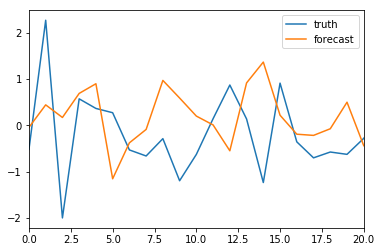

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


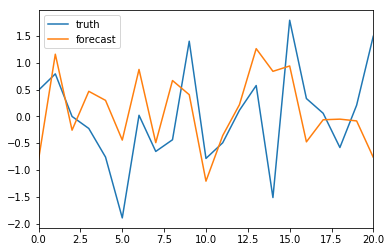

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


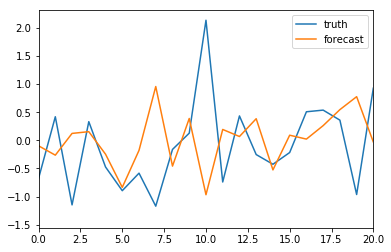

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


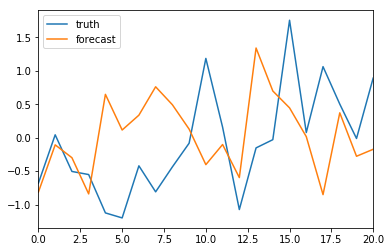

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


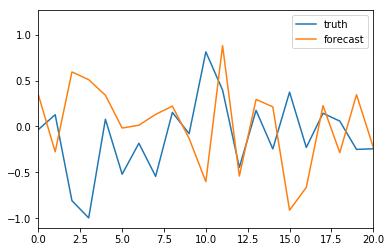

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


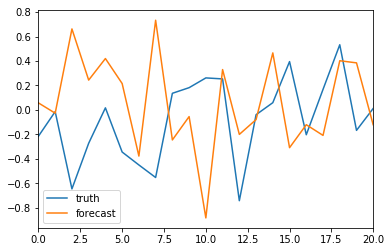

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


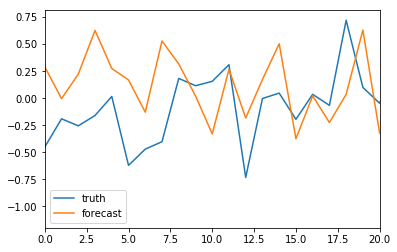

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


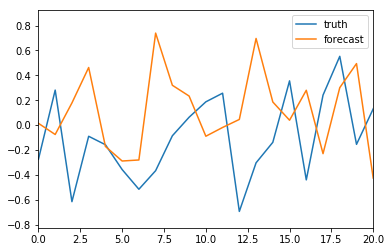

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


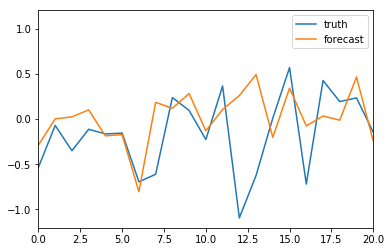

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


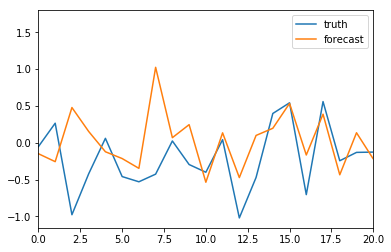

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


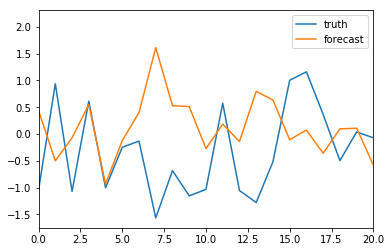

tecut = 27, tscut = 1.0
Loading from tos
Loading from cuments/SeaIceData/ERA5/tos_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing climotology...
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.34926342964172363 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


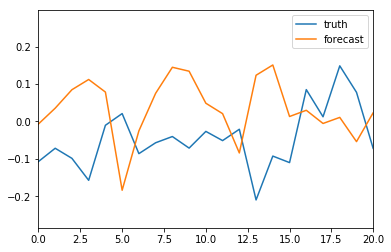

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


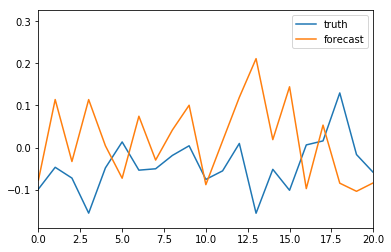

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


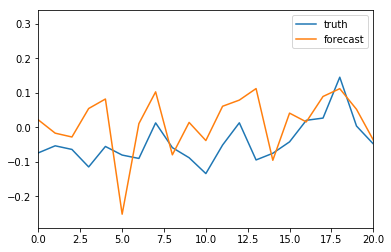

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


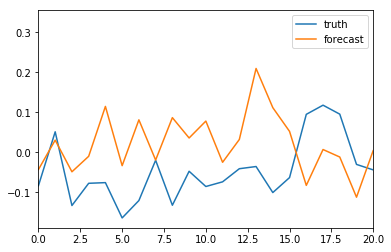

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


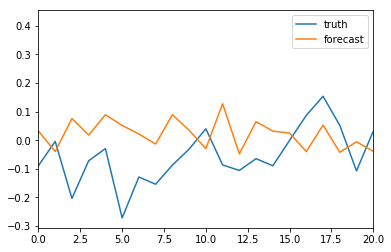

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


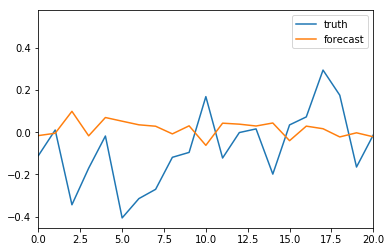

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


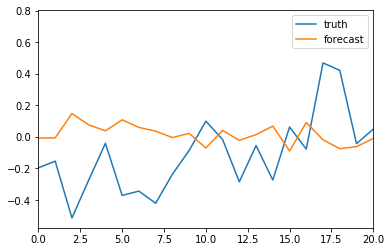

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


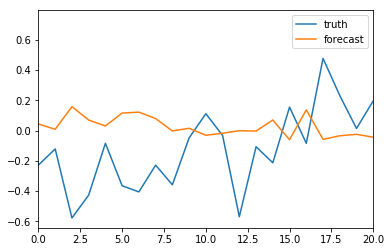

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


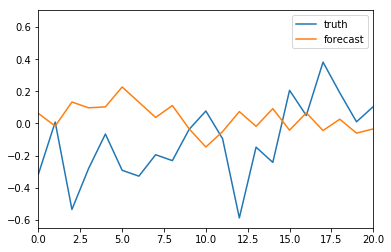

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


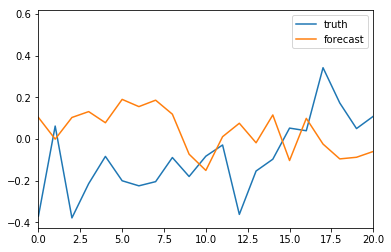

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


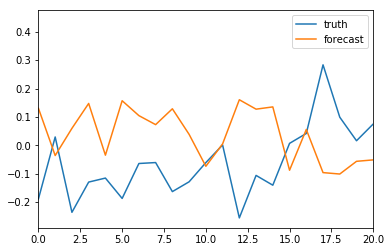

tecut = 27, tscut = 1.0
Loading from sic
Loading from cuments/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
removing climotology...
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.349257230758667 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


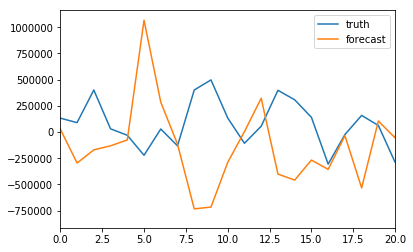

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


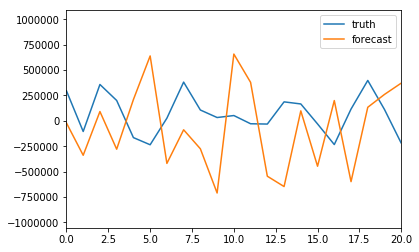

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


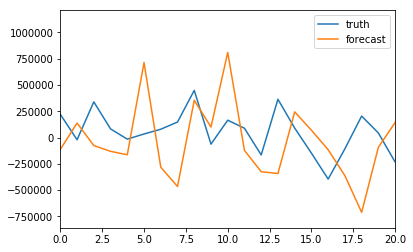

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


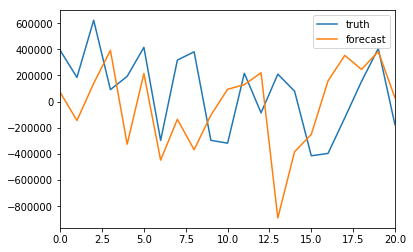

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


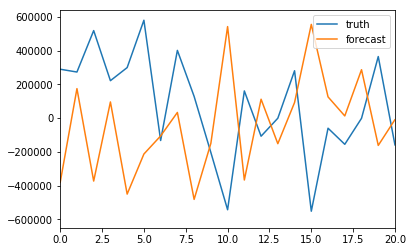

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


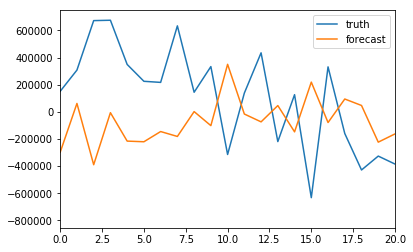

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


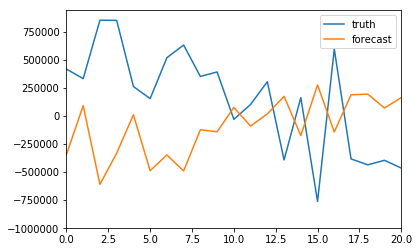

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


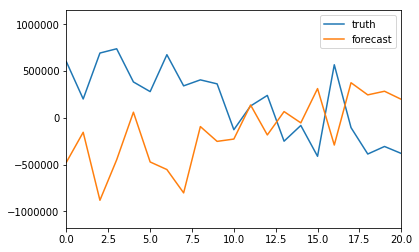

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


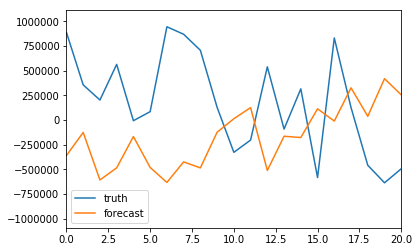

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


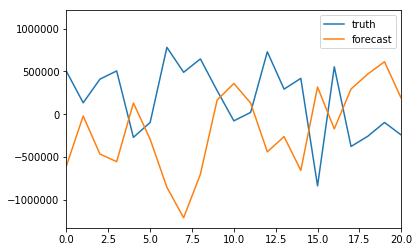

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (58320, 26)
Forecast_anom shape: (58320, 26)
changing cellarea units from m2 to km^2


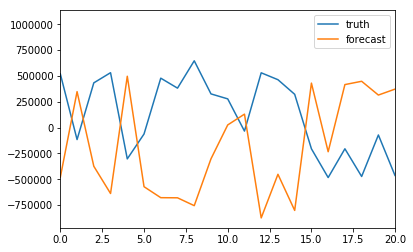

In [369]:
forecast_validation = rf.validate_forecast_monthly(forecast, exp_setup['limvars'], 1, exp_setup, LIMd, f_folder, 
                                                   iplot=True, save=master_save)

In [302]:
# L_filename = ('Forecast_validation_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_monthly = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from sk/chaos/mkb22/Documents/SeaIceData/ERA5/areacella_grid05.nc
latitude cutoff detected: 50
Loading from sk/chaos/mkb22/Documents/SeaIceData/ERA5/areacello_grid05.nc
latitude cutoff detected: 50
tecut = 27, tscut = 1.0
Loading from tas
Loading from cuments/SeaIceData/ERA5/tas_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 50
-----------------------------------------------------
completed in 89.52110862731934 seconds
-----------------------------------------------------
Lag 0
Trained using all months...
Truth_anom shape: (58320, 312)
Forecast_anom shape: (58320, 312)
changing cellarea units from m2 to km^2


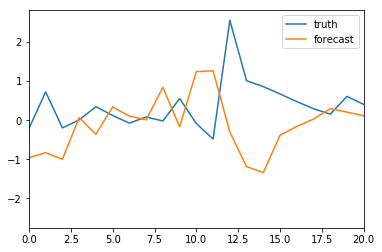

Lag 1
Trained using all months...
Truth_anom shape: (58320, 311)
Forecast_anom shape: (58320, 311)
changing cellarea units from m2 to km^2


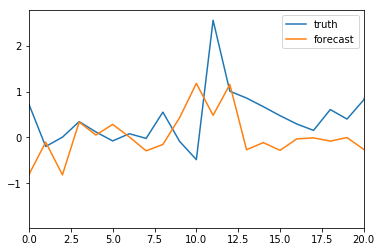

Lag 2
Trained using all months...
Truth_anom shape: (58320, 310)
Forecast_anom shape: (58320, 310)
changing cellarea units from m2 to km^2


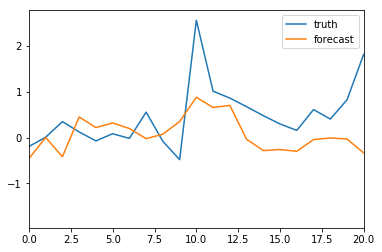

Lag 3
Trained using all months...
Truth_anom shape: (58320, 309)
Forecast_anom shape: (58320, 309)
changing cellarea units from m2 to km^2


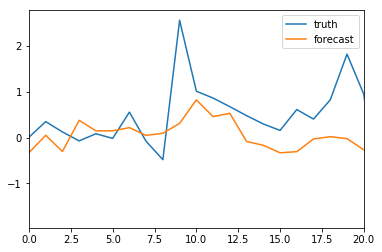

Lag 4
Trained using all months...
Truth_anom shape: (58320, 308)
Forecast_anom shape: (58320, 308)
changing cellarea units from m2 to km^2


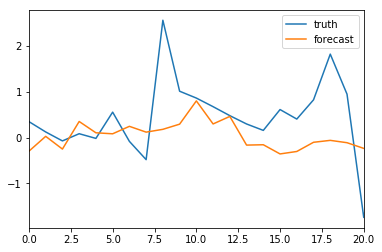

Lag 5
Trained using all months...
Truth_anom shape: (58320, 307)
Forecast_anom shape: (58320, 307)
changing cellarea units from m2 to km^2


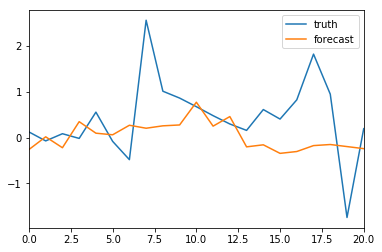

Lag 6
Trained using all months...
Truth_anom shape: (58320, 306)
Forecast_anom shape: (58320, 306)
changing cellarea units from m2 to km^2


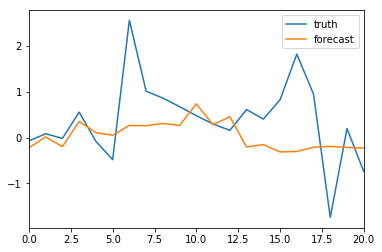

tecut = 27, tscut = 1.0
Loading from tos
Loading from cuments/SeaIceData/ERA5/tos_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with ze

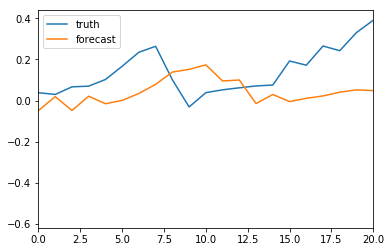

Lag 1
Trained using all months...
Truth_anom shape: (58320, 311)
Forecast_anom shape: (58320, 311)
changing cellarea units from m2 to km^2


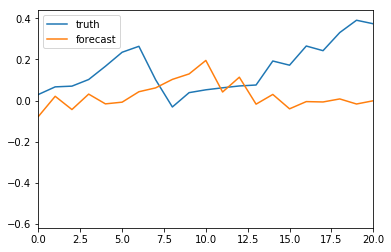

Lag 2
Trained using all months...
Truth_anom shape: (58320, 310)
Forecast_anom shape: (58320, 310)
changing cellarea units from m2 to km^2


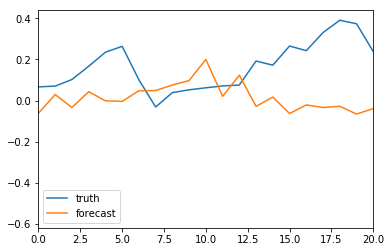

Lag 3
Trained using all months...
Truth_anom shape: (58320, 309)
Forecast_anom shape: (58320, 309)
changing cellarea units from m2 to km^2


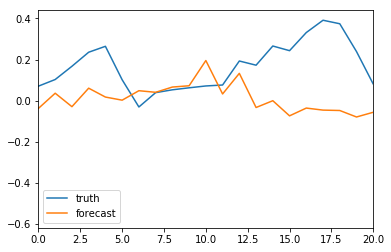

Lag 4
Trained using all months...
Truth_anom shape: (58320, 308)
Forecast_anom shape: (58320, 308)
changing cellarea units from m2 to km^2


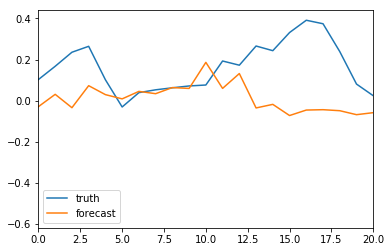

Lag 5
Trained using all months...
Truth_anom shape: (58320, 307)
Forecast_anom shape: (58320, 307)
changing cellarea units from m2 to km^2


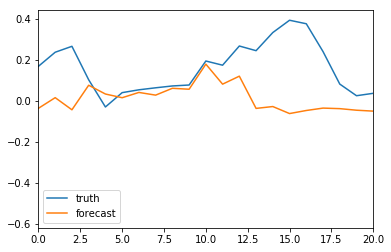

Lag 6
Trained using all months...
Truth_anom shape: (58320, 306)
Forecast_anom shape: (58320, 306)
changing cellarea units from m2 to km^2


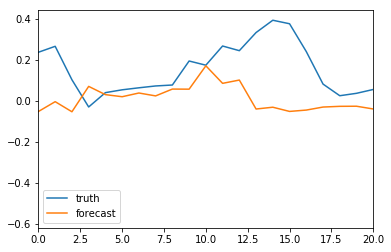

tecut = 27, tscut = 1.0
Loading from sic
Loading from cuments/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_grid05.nc
time dimension: 1980 - 2005
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...


KeyboardInterrupt: 

In [370]:
forecast_validation_lags = rf.validate_forecast_lagged(forecast, exp_setup['limvars'], exp_setup, LIMd, 
                                                       f_folder, iplot=True, save=master_save, 
                                                       detrend_truth=True)

In [ ]:
# L_filename = ('Forecast_validation_lagged_'+train_dsource+
#               '_ntrain_1850_2005_tas30_tos30_sit30_sic50_'+date_of_interest+'.pkl')

# L_filename = ('Forecast_validation_lagged_cmip6_mpi_hist_ntrain_1850_2005_validation_mpi_lm_kb'+
#               '_0_100_tas30_tos30_sit30_sic50_20210826.pkl')

# forecast_validation_lags = pickle.load(open(L_folder+L_filename, 'rb'))

### Testing error variance ratio: 

In [289]:
fdic_train = limkb.build_training_dic(exp_setup['train_dsource'])
fdic_valid = limkb.build_training_dic(exp_setup['valid_dsource'])

areacell, areacell_dict = limbuild.load_areacell_dict(fdic_train, lat_cutoff=exp_setup['lat_cutoff'],
                                                      remove_climo=False, detrend=False, verbose=False )
full_names, areawt_name, month_names = limbuild.load_full_names()

v = {}
validation_stats_lags = {}

#    nyear_valid = exp_setup['nyearstot'] - exp_setup['nyearsvalid']


Loading from Observations/areacello_CDR_NASA-Team_polar_stereo_25km_NH.nc
latitude cutoff detected: 50


In [456]:
var ='sic'

tecut = int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid'])
#        tecut = exp_setup['nyearstot'] - (int(exp_setup['nyears_startvalid']/12)+(exp_setup['nyearsvalid']))
if tecut <=0: 
    tecut = False
print('tecut = '+str(tecut) +', tscut = '+str(exp_setup['nyears_startvalid']/12))

X_var, _ = limkb.load_data(var, v, fdic_valid, remove_climo=True, detrend=True, verbose=True,
                           tscut=int(exp_setup['nyears_startvalid']/12), tecut=tecut, 
                           lat_cutoff=exp_setup['lat_cutoff'])

if var is 'sic':
    if np.nanmax(X_var)>1:
        print('Changing units of sic be a between 0 to 1')
        X_var = X_var/100

corr_tot = np.zeros((len(exp_setup['lags'])))
ce_tot = np.zeros((len(exp_setup['lags'])))
gm_var_ratio = np.zeros((len(exp_setup['lags'])))
valid_stats = {}


tecut = 38, tscut = 26.0
Loading from sic
Loading from Data/Observations/sic_goddard_merged_mon_v03r01_1979_2016.nc
time dimension: 2005 - 2016
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 50
-----------------------------------------------------
completed in 95.61396360397339 seconds
-----------------------------------------------------


In [461]:
#for i,lag in enumerate(exp_setup['lags']):
lag = 0
print('Lag '+str(lag))
#             [truth_anom, forecast_anom] = limbuild.gather_truth_forecast2(lag,var,exp_setup['mo'],X_var,
#                                                                           forecast['x_forecast_dcomp'],
#                                                                           exp_setup['nyearsvalid']*12,
#                                                                           LIMd['var_dict'],exp_setup['ntrain'],
#                                                                           exp_setup['nyears_startvalid'],
#                                                                           insamp=exp_setup['Insamp'])
[truth_anom, 
 forecast_anom] = limbuild.gather_truth_forecast_notime(lag,var,exp_setup['mo'],X_var,
                                                        forecast['x_forecast_dcomp'],
                                                        LIMd['var_dict'],insamp=exp_setup['Insamp'])


print('Truth_anom shape: '+str(truth_anom.shape))
print('Forecast_anom shape: '+str(forecast_anom.shape))

Lag 0
Trained using all months...
Truth_anom shape: (109440, 144)
Forecast_anom shape: (109440, 144)


In [492]:
X_var.shape

(109440, 144)

In [462]:
units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
    
#Check cell area units: change all to km^2
if 'km' in units:
    acell = areacell[areawt_name[var]]
else: 
    print('changing cellarea units from '+
          str(areacell_dict[areawt_name[var]][areawt_name[var]]['units'])+' to km^2')
    acell = areacell[areawt_name[var]]*(1e-6)
    units = 'km^2'

In [489]:
## New error var calculations: 09/23/21
forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd['E_sic'],axis=1),0,atol=1e-5),np.nan,1)

rmse = np.nanmean((truth_anom-forecast_anom)**2,axis=1)
gm_rmse = statskb.global_mean(rmse*truth_error_var_mask,acell)
gsum_rmse = np.nansum(gm_var_ratio)

if lag == 0:
    gsum_rmse_lag0 = gsum_rmse
    
gsum_rmse_ratio = gsum_rmse/gsum_rmse_lag0


In [491]:
rmse.shape

(109440,)

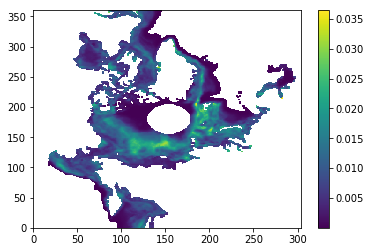

In [487]:
plt.pcolormesh(np.reshape(rmse*forecast_nan_mask, (360,304)))
#plt.plot(188,215,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

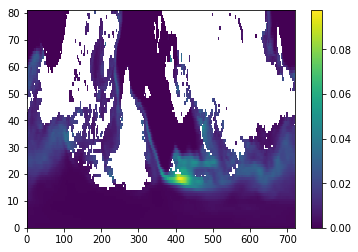

In [159]:
plt.pcolormesh(np.reshape(truth_error_var, (81, 720)))
#plt.plot(188,215,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

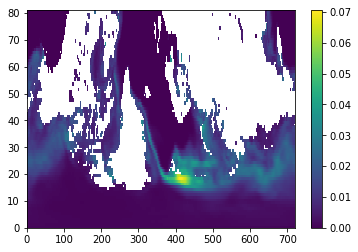

In [155]:
plt.pcolormesh(np.reshape(error_var, (81, 720)))
#plt.plot(188,250,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

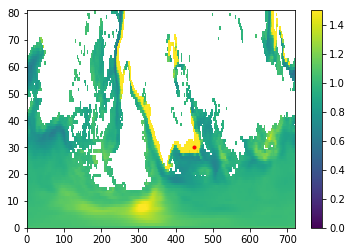

In [160]:
plt.pcolormesh(np.reshape(gm_var_ratio_masked, (81, 720)),vmin=0, vmax=1.5)
plt.plot(450,30,marker='.',color='r')
plt.colorbar()
# plt.xlim(180,210)
# plt.ylim(200,280)

In [158]:
np.nanmax(gm_var_ratio_masked)

341.8962345898482

In [161]:
X_var_train_dt, _ = limkb.load_data(var, v, fdic_train, remove_climo=True, detrend=True, verbose=True,
                                 tscut=False, tecut=False, 
                                 lat_cutoff=exp_setup['lat_cutoff'])

Loading from sic
Loading from cuments/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_grid05.nc
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...
Working on month...3
Found with nans (not in satellite), going to fill with zeros...
Working on month...4
Found with nans (not in satellite), going to fill with zeros...
Working on month...5
Found with nans (not in satellite), going to fill with zeros...
Working on month...6
Found with nans (not in satellite), going to fill with zeros...
Working on month...7
Found with nans (not in satellite), going to fill with zeros...
Working on month...8
Found with nans (not in satellite), going to fill with zeros...
Working on month...9
Found with nans (not in satellite), going to fill with zeros...
Working on month...10
Found with nans (not in

In [162]:
X_var_train, _ = limkb.load_data(var, v, fdic_train, remove_climo=False, detrend=False, verbose=True,
                                 tscut=False, tecut=False, 
                                 lat_cutoff=exp_setup['lat_cutoff'])

Loading from sic
Loading from cuments/SeaIceData/ERA5/sic_monthly_ERA5_1979_2020_grid05.nc
latitude cutoff detected: 50
-----------------------------------------------------
completed in 0.08318066596984863 seconds
-----------------------------------------------------


In [187]:
504/12, forecast_anom.shape, 12*15, 42-16

(42.0, (58320, 192), 180, 26)

Text(0.5,1,'ERA5, January, Lat: 30/81, Lon: 450/720')

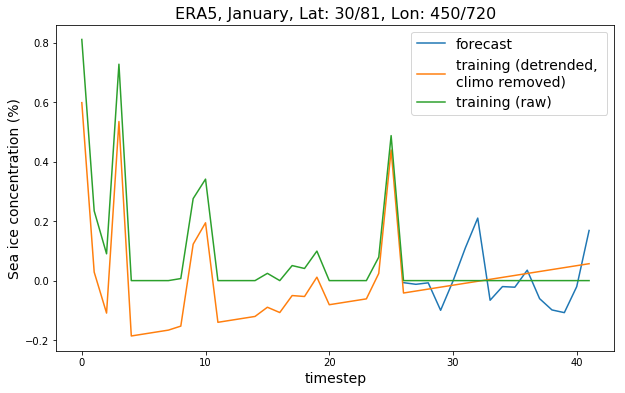

In [189]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.arange(26,26+16,1),np.reshape(forecast_anom, (81,720,16,12))[30,450,:,0], label='forecast')

plt.plot(np.reshape(X_var_train_dt, (81,720,42,12))[30,450,:,0], label='training (detrended, \nclimo removed)')
plt.plot(np.reshape(X_var_train, (81,720,42,12))[30,450,:,0], label='training (raw)')
plt.legend(fontsize=14)

#plt.xlim(300,504)

plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('ERA5, January, Lat: 30/81, Lon: 450/720', fontsize=16)

Text(0.5,1,'ERA5 Lat: 30/81, Lon: 450/720')

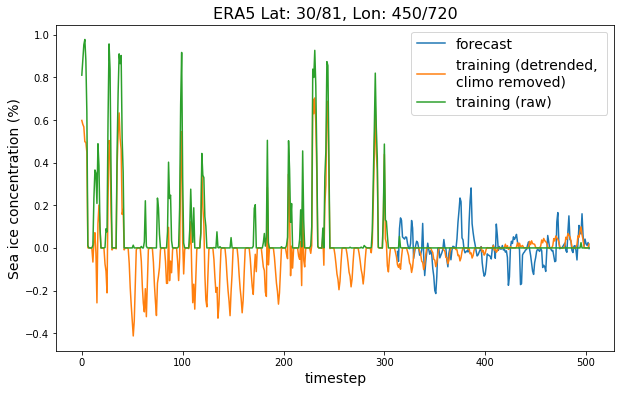

In [170]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.arange(504-191,504,1),np.reshape(forecast_anom, (81,720,191))[30,450,:], label='forecast')

plt.plot(np.reshape(X_var_train_dt, (81,720,504))[30,450,:], label='training (detrended, \nclimo removed)')
plt.plot(np.reshape(X_var_train, (81,720,504))[30,450,:], label='training (raw)')
plt.legend(fontsize=14)

#plt.xlim(300,504)

plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('ERA5 Lat: 30/81, Lon: 450/720', fontsize=16)

Text(0.5,1,'Lat: 188/360, Lon: 215/304')

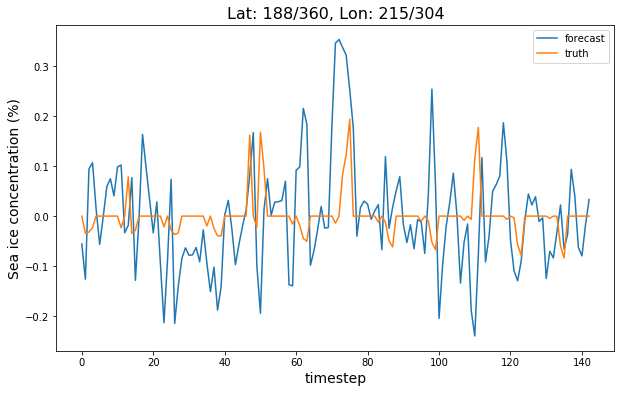

In [291]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.plot(np.reshape(forecast_anom, (360,304,143))[188,215,:], label='forecast')
plt.plot(np.reshape(truth_anom, (360,304,143))[188,215,:], label='truth')
plt.legend()
plt.xlabel('timestep', fontsize=14)
plt.ylabel('Sea ice concentration (%)', fontsize=14)
plt.title('Lat: 188/360, Lon: 215/304', fontsize=16)

## Run AR1 Forecast: 

Loading from Observations/areacello_CDR_NASA-Team_polar_stereo_25km_NH.nc
latitude cutoff detected: 50
only one variable detected.
tecut = 38, tscut = 26.0
Loading from sic
Loading from Data/Observations/sic_goddard_merged_mon_v03r01_1979_2016.nc
time dimension: 2005 - 2016
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 50
-----------------------------------------------------
completed in 96.08936214447021 seconds
-----------------------------------------------------
Month 0
Trained using month 0...
Validating against month 0
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


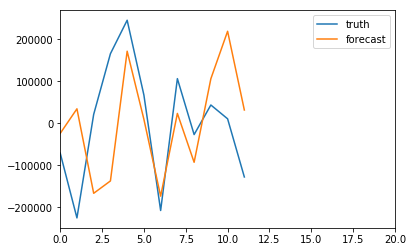

Month 1
Trained using month 1...
Validating against month 1
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


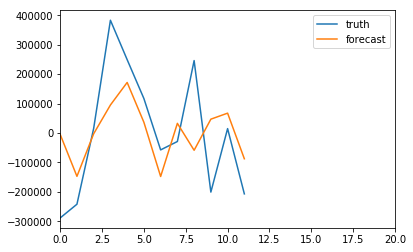

Month 2
Trained using month 2...
Validating against month 2
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


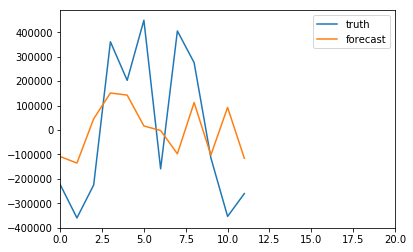

Month 3
Trained using month 3...
Validating against month 3
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


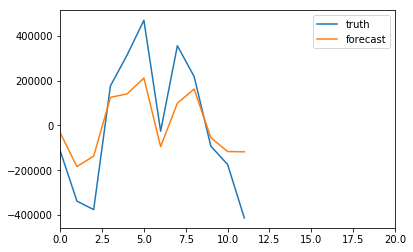

Month 4
Trained using month 4...
Validating against month 4
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


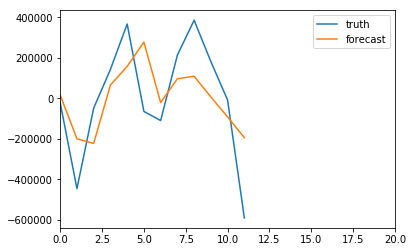

Month 5
Trained using month 5...
Validating against month 5
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


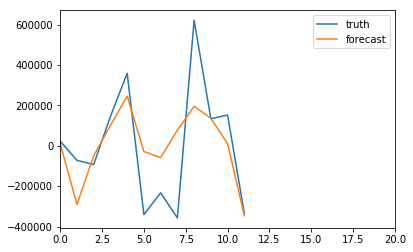

Month 6
Trained using month 6...
Validating against month 6
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


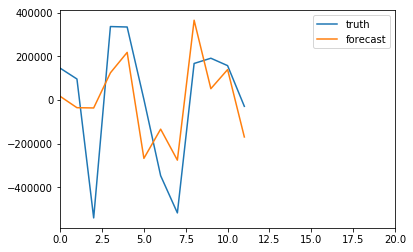

Month 7
Trained using month 7...
Validating against month 7
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


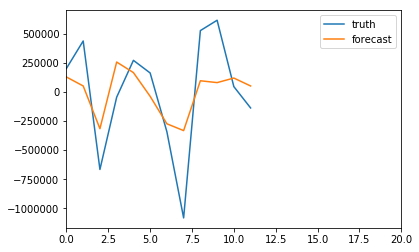

Month 8
Trained using month 8...
Validating against month 8
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


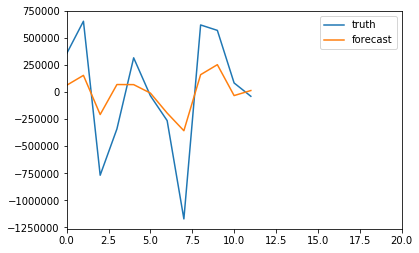

Month 9
Trained using month 9...
Validating against month 9
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


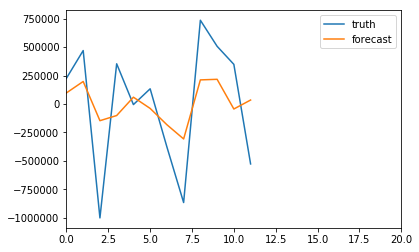

Month 10
Trained using month 10...
Validating against month 10
Truth_anom shape: (109440, 12)
Forecast_anom shape: (109440, 12)


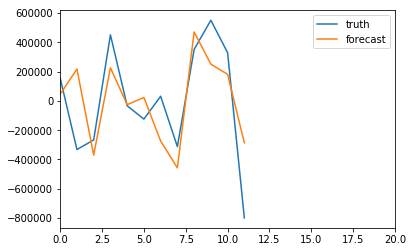

In [1090]:
valid_vars=limvars
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast = rf.ar1_forecast_valid_by_month(LIMd['P_train'], forecast['P_train_valid'], LIMd,
                                         exp_setup, valid_vars, month_names, ar1f_folder, forecast,
                                         lag=None, iplot=True, save=master_save, save_decomp=False)

In [1091]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_monthly_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast = pickle.load(open(L_folder+L_filename, 'rb'))

Loading from Observations/areacello_CDR_NASA-Team_polar_stereo_25km_NH.nc
latitude cutoff detected: 50
only one variable detected.
only one variable detected.
only one variable detected.
only one variable detected.
only one variable detected.
only one variable detected.
tecut = 38, tscut = 26.0
Loading from sic
Loading from Data/Observations/sic_goddard_merged_mon_v03r01_1979_2016.nc
time dimension: 2005 - 2016
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
latitude cutoff detected: 50
-----------------------------------------------------
completed in 97.56480860710144 seconds
-----------------------------------------------------
Lag 1
Trained using all months...
Truth_anom shape: (109440, 143)
Forecast_anom shape: (109440, 143)


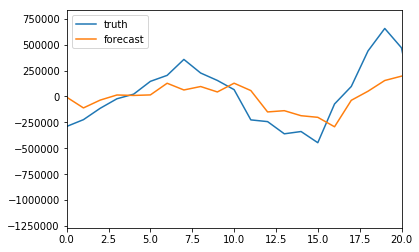

Lag 2
Trained using all months...
Truth_anom shape: (109440, 142)
Forecast_anom shape: (109440, 142)


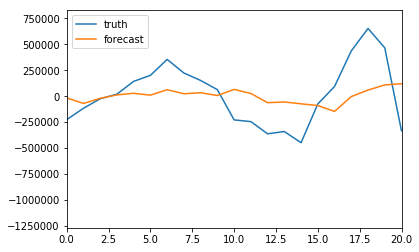

Lag 3
Trained using all months...
Truth_anom shape: (109440, 141)
Forecast_anom shape: (109440, 141)


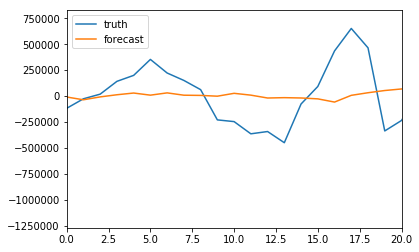

Lag 4
Trained using all months...
Truth_anom shape: (109440, 140)
Forecast_anom shape: (109440, 140)


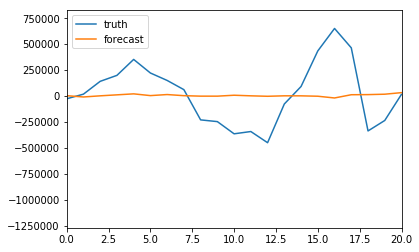

Lag 5
Trained using all months...
Truth_anom shape: (109440, 139)
Forecast_anom shape: (109440, 139)


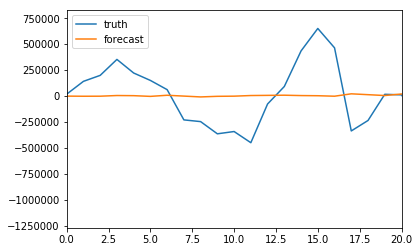

Lag 6
Trained using all months...
Truth_anom shape: (109440, 138)
Forecast_anom shape: (109440, 138)


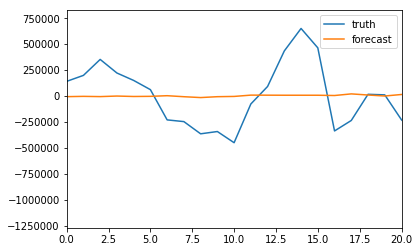

In [1092]:
ar1f_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'

ar1cast_lags = rf.ar1_forecast_valid_by_lag(LIMd['P_train'], forecast['P_train_valid'], LIMd, exp_setup, 
                                            exp_setup['limvars'], month_names, ar1f_folder, forecast,
                                            iplot=True, save=master_save, save_decomp=False,
                                            detrend_truth=False)

In [1093]:
# L_folder = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIMs_saved/'
# L_filename = ('AR1_forecast_lagged_'+train_dsource+
#               '_ntrain_1850_1999_tas30_tos30_psl30_sit30_sic50_'+date_of_interest+'.pkl')

# ar1cast_lags = pickle.load(open(L_folder+L_filename, 'rb'))

## Validation by lag: 

In [ ]:
if 'cmip6' in train_dsource: 
    tcmip='CMIP6'
elif 'era' in train_dsource:
    tcmip=''
elif 'satellite' in train_dsource: 
    tcmip=''
else: 
    tcmip='CMIP5'

var = 'sic'
# start_tim = exp_setup['nyears_startvalid']
# end_tim = exp_setup['nyears_startvalid']+(exp_setup['nyearsvalid']*12)
valid_yrs_str = (str(forecast['var_dict_valid'][var]['time'][0])[:4]+'_'+
                 str(forecast['var_dict_valid'][var]['time'][-1])[:4])

if 'hist' in train_dsource:
    texp = 'Historical'
elif 'lm' in train_dsource: 
    texp = 'LM'
elif 'ssp585' in train_dsource: 
    texp = 'SSP585'
elif 'era5' in train_dsource: 
    texp = 'ERA5'
elif 'satellite' in train_dsource: 
    texp = 'Satellite'
    
if 'hist' in valid_dsource:
    vexp = 'Historical'
elif 'lm' in valid_dsource: 
    vexp = 'LM'
elif 'ssp585' in valid_dsource: 
    vexp = 'SSP585'
elif 'era5' in valid_dsource: 
    vexp = 'ERA5'
elif 'satellite' in valid_dsource: 
    vexp = 'Satellite'
    
if 'cesm2' in train_dsource:
    tmod = 'CESM2'
elif 'mpi' in train_dsource: 
    tmod = 'MPI'
elif 'gfdl' in train_dsource: 
    tmod = 'GFDL'
elif 'ccsm4' in train_dsource: 
    tmod = 'CCSM4'
elif 'era5' in train_dsource: 
    tmod = ''
elif 'satellite' in train_dsource: 
    tmod = ''
    
if 'cesm2' in valid_dsource:
    vmod = 'CESM2'
elif 'mpi' in valid_dsource: 
    vmod = 'MPI'
elif 'gfdl' in valid_dsource: 
    vmod = 'GFDL'
elif 'ccsm4' in valid_dsource: 
    vmod = 'CCSM4'
elif 'era5' in valid_dsource: 
    vmod = ''
elif 'satellite' in valid_dsource: 
    vmod = ''
    
if exp_setup['Weight'] is True: 
    wt_addin = ' '
else: 
    wt_addin = '(no area weighting)'
    
if exp_setup['detrend'] is True: 
    tr_addin = ' '
else: 
    tr_addin = ' (trended)'

In [305]:
exp_setup['mod_filename']

'_ntrunc40_monthall_era5_latcutoff_50_wtTrue_dtFalse_ntrain_1979_2012_20211012.pkl'

NameError: name 'ar1cast_lags' is not defined

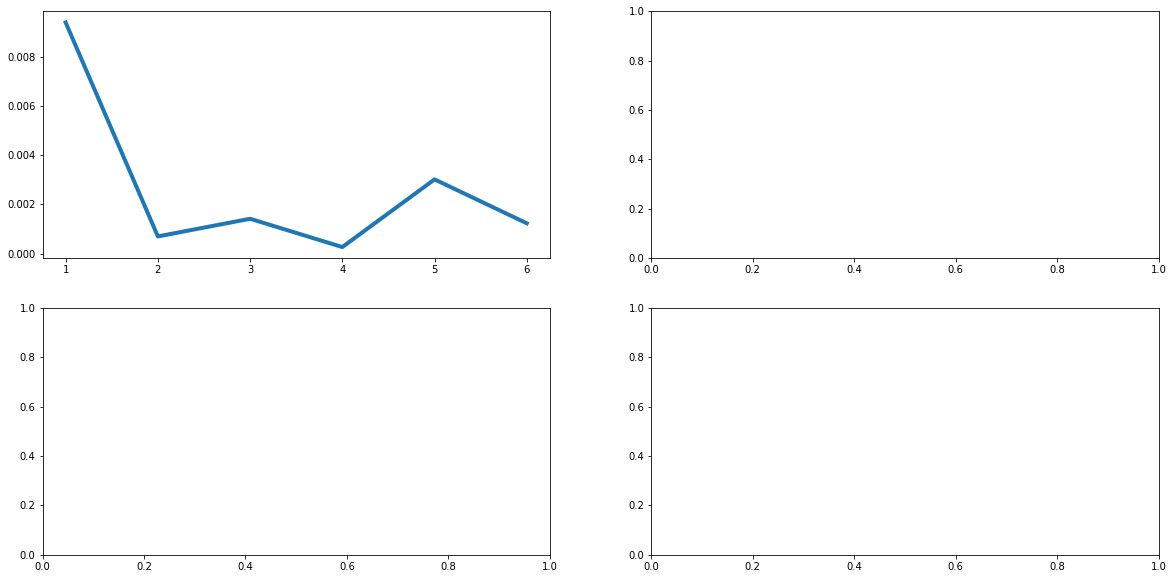

In [306]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][1:]**2, 
               label='Correlation',linewidth=4)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
               label='AR(1) Correlation',linewidth=4, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(exp_setup['lags'][1:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][1:],
               label='CE',linewidth=3.0)
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
               label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(1,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='upper right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

In [218]:
exp_setup['mod_filename']

'_ntrunc40_monthall_era5_latcutoff_50_wtTrue_dtTrue_ntrain_1979_2012_20211012.pkl'

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(['sic']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, 
               label='Correlation',linewidth=4)
#     axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['corr_tot'][:-1]**2, 
#                label='AR(1) Correlation',linewidth=4, 
#                linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:],
               label='CE',linewidth=3.0)
#     axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['ce_tot'][:-1],
#                label='AR(1) CE',linewidth=3.0, 
#                linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,1)
    axs.set_xlim(0,8)
    axs.grid(axis='both')
#    ax.set_title(var, fontsize=14)
#    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(np.round(np.mean(validation_stats[var]['corr_tot']**2),2))),fontsize=14)
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else: 
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='upper right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.85)

In [1099]:
forecast_validation_lags['validation_stats_lags'][var]['corr_tot'][:]**2, forecast_validation_lags['validation_stats_lags'][var]['ce_tot'][:]

(array([8.77791163e-01, 4.52109017e-01, 1.61266341e-01, 4.11248667e-02,
        3.60026423e-03, 3.23107092e-04, 1.03960398e-03]),
 array([ 0.82734094,  0.43202439,  0.16103999,  0.0347903 , -0.01803892,
        -0.01802274, -0.00609155]))

In [1100]:
forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:]

array([0.00844092, 0.01204983, 0.01390693, 0.01438152, 0.01444475,
       0.01442545, 0.01437877])

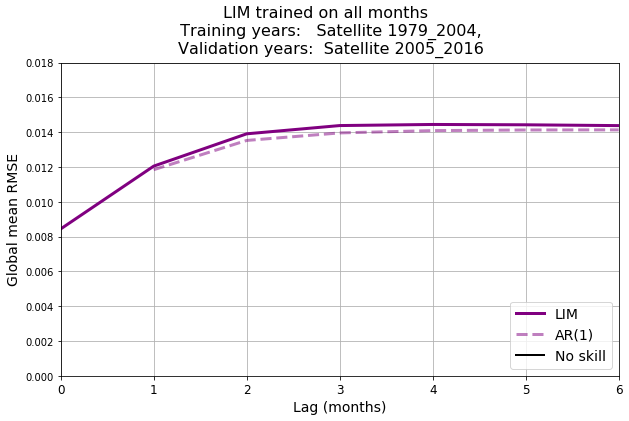

In [1101]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(exp_setup['limvars']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
    axs.set_ylim(0,0.018)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
#    axs.set_title(var, fontsize=14)
    
    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_ylabel('Global mean RMSE', fontsize=14)

plt.subplots_adjust(top=0.85)

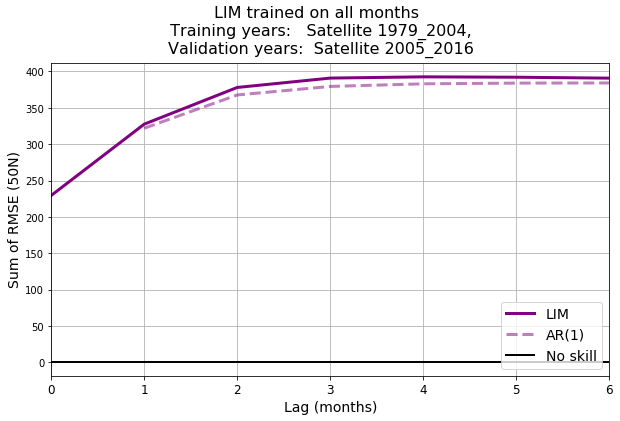

In [1102]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(exp_setup['limvars']):
    axs.plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gsum_rmse'][:], 
               label='LIM',linewidth=3.0, color='purple')
    axs.plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gsum_rmse'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(np.arange(0,11,1),fontsize=12)
#    axs.set_ylim(0,1.2)
    axs.set_xlim(0,6)
    axs.grid(axis='both')
#    axs.set_title(var, fontsize=14)
    
    axs.axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months'+wt_addin+tr_addin+'\n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', \nValidation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_xlabel('Lag (months)', fontsize=14)
axs.set_ylabel('Sum of RMSE (50N)', fontsize=14)

plt.subplots_adjust(top=0.85)

No handles with labels found to put in legend.


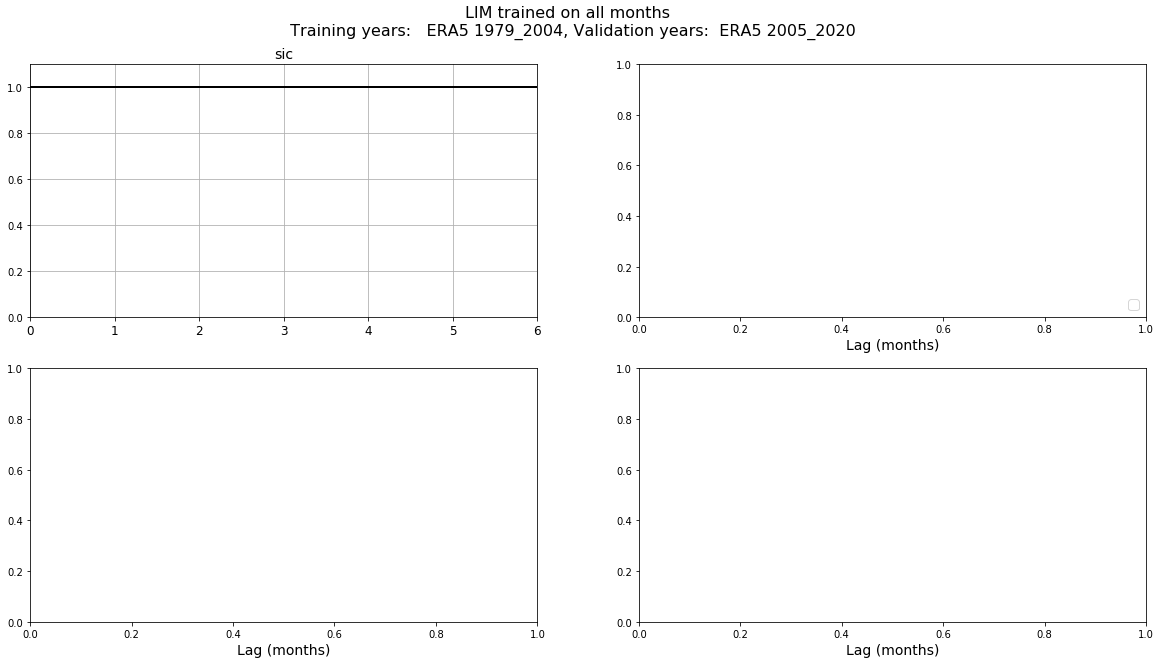

In [134]:
fig,axs = plt.subplots(2,2,figsize=(20,10))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(exp_setup['lags'][:],forecast_validation_lags['validation_stats_lags'][var]['gm_var_ratio'][:], 
               label='LIM',linewidth=3.0, color='purple')
    ax[i].plot(exp_setup['lags'][1:],ar1cast_lags['validation_stats_ar1_lags'][var]['gm_var_ratio'][:-1], 
               label='AR(1)',linewidth=3.0, linestyle='--', color='purple',alpha=0.5)

    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(np.arange(0,11,1),fontsize=12)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xlim(0,6)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    
    ax[i].axhline(1.0, color='k', linewidth=2, label='No skill')
    
if Insamp==True:     
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-22:-13]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[1].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Lag (months)', fontsize=14)
ax[1].set_xlabel('Lag (months)', fontsize=14)
ax[3].set_xlabel('Lag (months)', fontsize=14)

plt.subplots_adjust(top=0.9)

## Validation by month: 

No handles with labels found to put in legend.


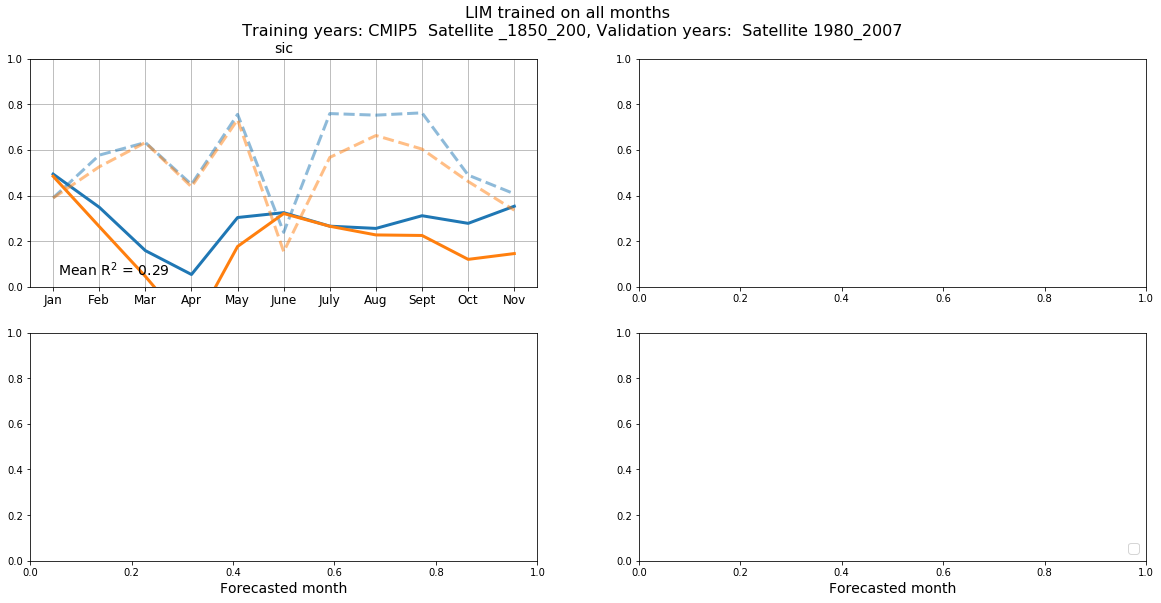

In [60]:
fig,axs = plt.subplots(2,2,figsize=(20,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(exp_setup['limvars']):
    ax[i].plot(forecast_validation['validation_stats'][var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    ax[i].plot(forecast_validation['validation_stats'][var]['ce_tot'],label='CE',linewidth=3.0)
    ax[i].plot(ar1cast['validation_stats_ar1'][var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    ax[i].set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)#, rotation=45)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=14)
    mn = np.round(np.mean(forecast_validation['validation_stats'][var]['corr_tot']**2),2)
    ax[i].text(0.1,0.05, ("Mean R$^2$ = "+str(mn)),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


ax[3].legend(loc='lower right', fontsize=14)
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.9)

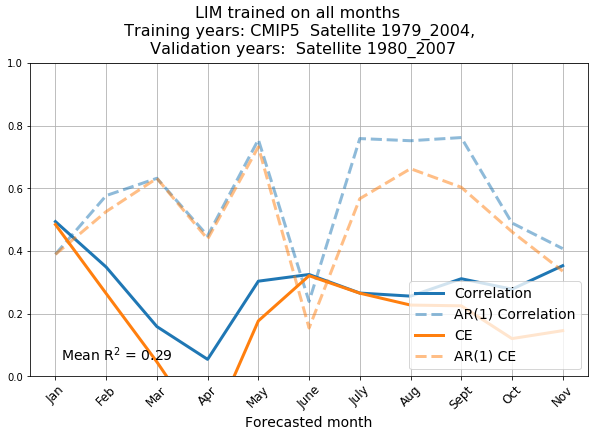

In [61]:
fig,axs = plt.subplots(1,1,figsize=(10,6))
#fig,axs= plt.subplots(2, 2)

for i,var in enumerate(['sic']):
    axs.plot(forecast_validation['validation_stats'][var]['corr_tot']**2, label='Correlation',linewidth=3.0)
    axs.plot(ar1cast['validation_stats_ar1'][var]['corr_tot']**2, label='AR(1) Correlation',linewidth=3.0, 
               linestyle='--', color='tab:blue',alpha=0.5)

    axs.plot(forecast_validation['validation_stats'][var]['ce_tot'],label='CE',linewidth=3.0)
    axs.plot(ar1cast['validation_stats_ar1'][var]['ce_tot'],label='AR(1) CE',linewidth=3.0, 
               linestyle='--', color='tab:orange', alpha=0.5)

    axs.set_ylim(0,1)
#     ax[i].set_xlim(0,10)
    axs.set_xticks(np.arange(0,11,1))
    axs.set_xticklabels(month_names,fontsize=12, rotation=45)
    axs.grid(axis='both')
#    ax[i].set_title(var, fontsize=14)
    mn = np.round(np.mean(forecast_validation['validation_stats'][var]['corr_tot']**2),2)
    axs.text(0.1,0.05, ("Mean R$^2$ = "+str(mn)),fontsize=14)

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
# #                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)

else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_sic_filename'][-22:-13]+', \n Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)

# ax[i].text(0.1,0.05, ("Training years: "+str(850)+'-'+str(850+ntrain*1000)),fontsize=14)
# ax[i].text(0.1,0.05, ("Validation years: "+str(850+ntrain*1000)+'-1850'),fontsize=14)


axs.legend(loc='lower right', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)
axs.set_xlabel('Forecasted month', fontsize=14)

plt.subplots_adjust(top=0.85)

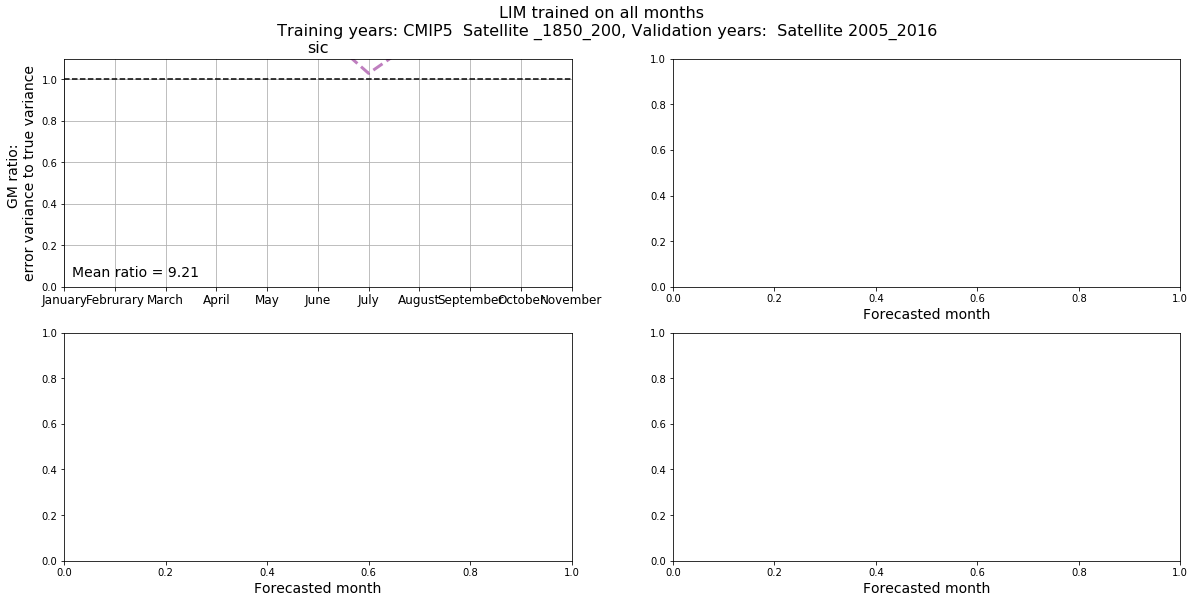

In [76]:
fig,axs = plt.subplots(2,2,figsize=(20,9))
#fig,axs= plt.subplots(2, 2)

ax = axs.flatten()

for i,var in enumerate(limvars):
    ax[i].plot(forecast_validation['validation_stats'][var]['gm_var_ratio'],linewidth=3.0, color='purple')

    ax[i].plot(ar1cast['validation_stats_ar1'][var]['gm_var_ratio'],linewidth=3.0, color='purple', 
               linestyle='--', alpha=0.5)

#    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,10)
    ax[i].set_ylim(0,1.1)
    ax[i].set_xticks(np.arange(0,11,1))
    ax[i].set_xticklabels(month_names,fontsize=12)
    ax[i].grid(axis='both')
    ax[i].set_title(var, fontsize=16)
    ax[i].text(0.15,0.05, ("Mean ratio = "+str(np.round(np.mean(forecast_validation['validation_stats'][var]['gm_var_ratio']),2))),
               fontsize=14)
    ax[i].axhline(1.0,color='k',linestyle='--')

if Insamp==True:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
#                  ', Validation years: Historical'+str(850)+'-'+str(int(850+ntrain*1000))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+str(int(850+ntrain*1000))+
                 ', Validation years: Historical'), fontsize=16)
else:     
#     plt.suptitle(('LIM trained on all months \n Training years: '+str(850)+'-'+
#                   str(int(850+ntrain*1000))+', Validation years: '+
#                   str(int(850+ntrain*1000))+'-'+str(int(850+ntrain*1000+nvalidtimes/12))), fontsize=16)
    plt.suptitle(('LIM trained on all months \n Training years: '+tcmip+' '+tmod+' '+texp+' '+
                  exp_setup['mod_filename'][-23:-14]+', Validation years: '+vmod+' '+vexp+' '+
                  valid_yrs_str), fontsize=16)
    
ax[2].set_xlabel('Forecasted month', fontsize=14)
ax[1].set_xlabel('Forecasted month', fontsize=14)
ax[3].set_xlabel('Forecasted month', fontsize=14)
ax[0].set_ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

plt.subplots_adjust(top=0.9)
#plt.tight_layout()

In [ ]:
LIMd['var_dict']['sic']['lat'].shape

In [ ]:
LIMd['var_dict']['sic']['var_ndof']/LIMd['var_dict']['sic']['lat'].shape[0]